In [16]:
import requests
import json

# URL de destino
url = "https://picota.io/api/1.0.0/digital-twin/f728aaa7-8648-4b55-8276-97a14217c063/subject/hogar01/inference"

payload = {
  "instant": "2012-02-28T00:00:00Z",
  "capitalProvincia": False,
  "tamanoMunicipio": 5,
  "densidad": 3,
  "superficie": 145.0,
  "tipoCasa": 3,
  "aguaCaliente": True,
  "calefaccion": False,
  "zonaResidencial": 5,
  "regimenTenencia": 5,
  "comidasTotales": 70.0,
  "miembros:estudiantes": 0,
  "miembros:noEstudiantes": 2,
  "miembros:ocupados": 1.0,
  "miembros:noOcupados": 2,
  "miembros:activos": 2.0,
  "miembros:noActivos": 1,
  "miembros:ancianos:masculinos": 0,
  "miembros:ancianos:femeninos": 0,
  "miembros:adultos:masculinos": 1,
  "miembros:adultos:femeninos": 1,
  "miembros:ninos:femeninos": 0,
  "miembros:ninos:masculinos": 1,
  "miembros:conIngresos:masculinos": 1,
  "miembros:conIngresos:femeninos": 1,
  "miembros:sinIngresos:masculinos": 1,
  "miembros:sinIngresos:femeninos": 0,
  "edadSp": 34,
  "espanolSp": True,
  "educacionSuperiorSp": True,
  "fuentePrincipalIngresos": "pension",
  "numeroViviendasAdicionales": 0.0,
  "ingresosNetos": 16530.130637524402,
  "gastoNoMonetario": 5259.437742307094,
  "tasaAhorro": 0.3336368653421633,
  "temperaturaMedia": 19.62,
  "tasaParo": 34.4,
  "inflacion": 2.6,
  "España.tipoInteres": 0.75,
  "España.tasaCambioEurUsd": 1.29,
  "ipc": 93.12816666666669,
  "gastoMonetario:productosAlimenticios11": 3202.161309070024,
  "gastoMonetario:bebidasNoAlcoholicas12": 301.8249921844587,
  "gastoMonetario:bebidasAlcoholicas21": 41.516071629263074,
  "gastoMonetario:tabaco22": 0.0,
  "gastoMonetario:articulosDeVestir31": 458.899382248031,
  "gastoMonetario:calzado32": 0.0,
  "gastoMonetario:alquileresRealesDeLaVivienda41": 0.0,
  "gastoMonetario:mantenimientoDeLaVivienda43": 0.0,
  "gastoMonetario:suministroDeAgua44": 257.3896921865379,
  "gastoMonetario:electricidadGasOtrosCombustibles45": 499.48660848726655,
  "gastoMonetario:mueblesRevestimientos51": 26.53843971507028,
  "gastoMonetario:textilesParaElHogar52": 0.0,
  "gastoMonetario:grandesElectrodomesticos53": 21.521015956439808,
  "gastoMonetario:utensiliosDelHogar54": 150.84614999294166,
  "gastoMonetario:herramientasCasaJardin55": 0.0,
  "gastoMonetario:bienesServiciosParaElHogar56": 73.51147801074468,
  "gastoMonetario:productosFarmaceuticos61": 177.30165708390237,
  "gastoMonetario:serviciosMedicosAmbulatorios62": 554.9602407541744,
  "gastoMonetario:serviciosHospitalarios63": 0.0,
  "gastoMonetario:compraDeVehiculos71": 33.17304964383786,
  "gastoMonetario:usoDeVehiculosPersonales72": 1230.3386517154802,
  "gastoMonetario:serviciosDeTransporte73": 108.11096878926756,
  "gastoMonetario:serviciosPostales81": 0.0,
  "gastoMonetario:equiposTelefonoFax82": 136.83882978083113,
  "gastoMonetario:serviciosTelefonoFax83": 1096.4024637784848,
  "gastoMonetario:audiovisualesTecnologia91": 35.18001914729005,
  "gastoMonetario:bienesDuraderosDeOcio92": 0.0,
  "gastoMonetario:ocioJardineriaYMascotas93": 305.7725850920754,
  "gastoMonetario:serviciosRecreativosYCulturales94": 0.0,
  "gastoMonetario:prensaYPapeleria95": 67.2666514152922,
  "gastoMonetario:paquetesTuristicos96": 120.25230495891222,
  "gastoMonetario:educacionInfantilYPrimaria101": 0.0,
  "gastoMonetario:educacionSecundariaYPostsecundaria102": 0.0,
  "gastoMonetario:educacionSuperior103": 0.0,
  "gastoMonetario:educacionNoFormal104": 0.0,
  "gastoMonetario:restauracion111": 1120.8012417915277,
  "gastoMonetario:alojamiento112": 198.44118296943805,
  "gastoMonetario:cuidadosPersonales121": 308.6171740990345,
  "gastoMonetario:efectosPersonales123": 50.44791524586641,
  "gastoMonetario:proteccionSocial124": 0.0,
  "gastoMonetario:seguros125": 437.4612989157008,
  "gastoMonetario:serviciosFinancieros126": 0.0,
  "gastoMonetario:otrosServicios127": 0.0,
  "gastoMonetario:remesas128": 0.0
}


headers = {
    "Content-Type": "application/json"
}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print("Código de respuesta:", response.status_code)
try:
    print("Respuesta del servidor:", response.json())
except Exception as e:
    print("Error interpretando JSON:", response.text)

Código de respuesta: 200
Respuesta del servidor: [{'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:productosAlimenticios11', 'value': 2317.981757674608}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:bebidasNoAlcoholicas12', 'value': 302.47684953563606}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:bebidasAlcoholicas21', 'value': 214.64689442256358}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:tabaco22', 'value': 429.37080028052065}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:articulosDeVestir31', 'value': 992.4101075917346}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:calzado32', 'value': 264.6803651224449}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:alquileresRealesDeLaVivienda41', 'value': 287.7617873330777}, {'subject': 'main_49_4_1425420380', 'variable': 'gastoMonetario:mantenimientoDeLaVivienda43', 'value': 191.54967197420473}, {'subject': 'main_49

### Simulacion caso de uso IRPF

In [17]:
import pandas as pd
import os

In [18]:
df_tax_2025 = pd.read_csv('../../datamarts/tax_datamart_2025.tsv', sep='\t')

df_tax_2025.head()

,code,iva,igic,ipsi
0,11,11,4.0,2.0
1,12,10,7.0,0.5
2,21,21,13.5,10.0
3,22,21,20.0,10.0
4,31,21,3.0,4.0


In [19]:
df_inference_errors = pd.read_csv('../../datamarts/inference_errors.tsv', sep='\t')

df_inference_errors.head()

,subject,gastoMonetario,inference_error_pct
0,hogar07,productosAlimenticios11,2.53
1,hogar07,bebidasNoAlcoholicas12,2.11
2,hogar07,bebidasAlcoholicas21,0.32
3,hogar07,tabaco22,2.57
4,hogar07,articulosDeVestir31,1.31


In [20]:
import os
import pandas as pd

def leer_tsv_ccaa(ccaa, ruta_tsvs):
    """
    Lee el archivo hogar{ccaa}.tsv dentro del directorio indicado y devuelve
    solo las filas correspondientes al año 2023, filtrando por timestamp.

    Parameters
    ----------
    ccaa : str o int
        Código de dos dígitos de la CCAA (e.g. "01" o 1).
    ruta_tsvs : str
        Ruta al directorio donde están los archivos .tsv

    Returns
    -------
    pd.DataFrame
        DataFrame con el contenido del archivo leído, filtrado a año 2023.
    """
    # Formatear el número a dos dígitos si viene como entero
    ccaa_str = f"{int(ccaa):02d}"
    
    nombre_archivo = f"hogar{ccaa_str}.tsv"
    ruta_archivo = os.path.join(ruta_tsvs, nombre_archivo)
    
    if os.path.exists(ruta_archivo):
        print(f"✅ Leyendo archivo: {nombre_archivo}")
        df = pd.read_csv(ruta_archivo, sep='\t')

        # Filtrar solo filas cuyo timestamp empieza por "2023"
        if "timestamp" in df.columns:
            mask = df["timestamp"].astype(str).str.startswith("2023")
            df = df[mask]
        else:
            print("⚠️ Columna 'timestamp' no encontrada en el archivo. No se filtra por año.")
        
        return df
    else:
        print(f"⚠️ Archivo no encontrado: {nombre_archivo}")
        return pd.DataFrame()  # Devuelve DF vacío si no existe


In [ ]:
import numpy as np
import pandas as pd

def generar_incrementos_hijos(df):
    """
    Genera aleatoriamente cuántos hijos nacen en cada fila (0-3),
    y si son masculinos o femeninos.

    Devuelve tres arrays:
    - incrementos_m: número hijos masculinos por fila
    - incrementos_f: número hijos femeninos por fila
    - hijos_nuevos: total hijos nuevos por fila
    """
    df_new = df.copy()
    
    probabilidades = [0.4, 0.45, 0.12, 0.03]

    incrementos_m = np.zeros(len(df_new), dtype=int)
    incrementos_f = np.zeros(len(df_new), dtype=int)
    hijos_nuevos = np.zeros(len(df_new), dtype=int)

    for i in df_new.index:
        n_hijos = np.random.choice([0, 1, 2, 3], p=probabilidades)
        hijos_nuevos[i] = n_hijos

        for _ in range(n_hijos):
            if np.random.rand() < 0.5:
                incrementos_m[i] += 1
            else:
                incrementos_f[i] += 1

    return incrementos_m, incrementos_f, hijos_nuevos


In [22]:
def aplicar_incrementos(df, incrementos_m, incrementos_f, hijos_nuevos, importes_deduccion):
    """
    Aplica los incrementos de hijos al DataFrame y calcula el incremento en ingresosNetos.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame original.
    incrementos_m : np.array
        Incremento de niños masculinos por fila.
    incrementos_f : np.array
        Incremento de niñas femeninas por fila.
    hijos_nuevos : np.array
        Número de hijos nuevos por fila.
    importes_deduccion : dict
        Mapeo: número de hijos nuevos → importe deducción en euros.

    Returns
    -------
    df_new : pd.DataFrame
        DataFrame actualizado.
    total_incremento_euros : float
        Importe total sumado a ingresosNetos en todos los hogares.
    """

    df_new = df.copy()

    # Sumar hijos
    df_new["miembros:ninos:masculinos"] += incrementos_m
    df_new["miembros:ninos:femeninos"] += incrementos_f

    # Sumar un miembro que no percibe ingresos
    df_new["miembros:sinIngresos:masculinos"] += incrementos_m
    df_new["miembros:sinIngresos:femeninos"] += incrementos_f

    # un no estudiante no activo y no ocupado
    df_new["miembros:noEstudiantes"] += incrementos_m + incrementos_f
    df_new["miembros:noOcupados"] += incrementos_m + incrementos_f
    df_new["miembros:noActivos"] += incrementos_m + incrementos_f


    # Calcular importe por fila según nº de hijos nuevos
    incremento_por_fila = np.array([importes_deduccion.get(n, 0.0) for n in hijos_nuevos])

    # Actualizar ingresosNetos
    df_new["ingresosNetos"] += incremento_por_fila

    total_incremento_euros = incremento_por_fila.sum()

    return df_new, total_incremento_euros


In [ ]:
API_ID = "6c0d63e8-0ca5-45ac-bc2f-316db77f921a"

In [24]:
import requests
import json
import pandas as pd
from time import sleep

def predecir_gastos(df, bool_cols, ccaa, api_id, delay=0):
    """
    Envía filas de un DataFrame a la API y devuelve las predicciones en un DataFrame pivotado.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame con las filas que quieres enviar a la API.
    url : str
        URL del endpoint de la API.
    bool_cols : list
        Lista de nombres de columnas booleanas que deben convertirse a bool.
    delay : int
        Tiempo de espera entre peticiones (en segundos).

    Returns
    -------
    pd.DataFrame
        DataFrame con las predicciones, una fila por fila enviada.
    """

    url = f"https://picota.io/api/1.0.0/digital-twin/{api_id}/subject/hogar{ccaa}/inference"

    # DataFrame para acumular las predicciones
    df_preds_total = pd.DataFrame()

    for i, row in df.iterrows():

        payload = row.to_dict()

        # Convertir columnas booleanas
        for col in bool_cols:
            if col in payload:
                value = payload[col]
                if isinstance(value, str):
                    payload[col] = value.lower() == "true"
                else:
                    payload[col] = bool(value)

        # API espera "instant" en vez de "timestamp"
        payload["instant"] = payload.pop("timestamp")

        payload_json = json.dumps(payload)

        sleep(delay)

        response = requests.post(
            url,
            headers={"Content-Type": "application/json"},
            data=payload_json
        )

        print(f"✅ Fila {i} enviada. Código respuesta: {response.status_code}")

        try:
            pred = response.json()

            # Convertir respuesta a DataFrame
            df_pred = pd.DataFrame(pred)

            # Eliminar columna subject
            df_pred = df_pred.drop(columns="subject", errors="ignore")

            # Añadir índice de fila original
            df_pred["fila_original"] = i

            # Acumular
            df_preds_total = pd.concat([df_preds_total, df_pred], ignore_index=True)

        except Exception as e:
            print(f"⚠️ Error interpretando respuesta JSON (fila {i}):", response.text)

    # Pivotar el DataFrame para tener gastos como columnas
    if not df_preds_total.empty:
        df_pivot = df_preds_total.pivot_table(
            index="fila_original",
            columns="variable",
            values="value"
        ).reset_index()
    else:
        df_pivot = pd.DataFrame()

    return df_pivot


In [25]:
def calcular_diferencia(df_original, df_aumentado):
    """
    Calcula las diferencias numéricas entre dos DataFrames con la misma estructura.

    Parameters
    ----------
    df_original : pd.DataFrame
        DataFrame original.
    df_aumentado : pd.DataFrame
        DataFrame modificado.

    Returns
    -------
    pd.DataFrame
        DataFrame con las diferencias (df_aumentado - df_original).
    """
    # Restar uno menos el otro
    diferencia = df_aumentado.subtract(df_original, fill_value=0)
    
    return diferencia


In [26]:
def calcular_recaudacion(df_diferencia, ccaa_codigo, df_impuestos):
    """
    Calcula la recaudación fiscal adicional derivada del aumento de gasto por deducción por hijo.

    Parameters
    ----------
    df_diferencia : pd.DataFrame
        DataFrame con las diferencias de gastos (con columnas gastoMonetario:xxx).
    ccaa_codigo : int
        Código numérico de la comunidad autónoma:
            - 18 → Ceuta
            - 19 → Melilla
            - 5, 10, etc. → Canarias
            - resto → Península/Baleares (IVA)
    df_impuestos : pd.DataFrame
        DataFrame con columnas ['code', 'iva', 'igic', 'ipsi'].

    Returns
    -------
    float
        Importe total recaudado por el Estado sobre el aumento de gasto.
    """

    # Determinar el impuesto aplicable
    if ccaa_codigo == '18' or ccaa_codigo == '19':
        impuesto = "ipsi"
    elif ccaa_codigo == '05':
        impuesto = "igic"
    else:
        impuesto = "iva"

    total_recaudacion = 0.0

    # Recorrer todas las columnas de gasto
    for col in df_diferencia.columns:
        if col.startswith("gastoMonetario:"):
            try:
                # Quitar el prefijo
                nombre = col.replace("gastoMonetario:", "")
                
                # Extraer los últimos dígitos que sean números
                codigo_str = ""
                for c in reversed(nombre):
                    if c.isdigit():
                        codigo_str = c + codigo_str
                    else:
                        break

                if codigo_str == "":
                    continue

                codigo = int(codigo_str)

                # Buscar en la tabla de impuestos
                fila_imp = df_impuestos[df_impuestos["code"] == codigo]

                if not fila_imp.empty:
                    tipo_impositivo = float(fila_imp[impuesto].values[0])

                    if tipo_impositivo > 0:
                        gasto_extra = df_diferencia[col].sum()
                        recaudacion = gasto_extra * tipo_impositivo / 100
                        total_recaudacion += recaudacion

            except Exception as e:
                print(f"⚠️ Error procesando columna {col}: {e}")

    return total_recaudacion


In [27]:
bool_cols = [
    'capitalProvincia', 'aguaCaliente', 'calefaccion', 
    'espanolSp', 'educacionSuperiorSp'
]

In [ ]:
def unir_predicciones_y_errores(df_pred, df_errors):
    """
    Une predicciones con el DataFrame de errores.
    Devuelve DataFrame largo con columnas:
        subject, gastoMonetario, prediccion, minimo, maximo
    """

    # Pasar df_pred a formato largo
    df_long = df_pred.melt(
        id_vars=["subject"],
        var_name="gastoMonetario",
        value_name="prediccion"
    )

    # Quitar prefijo gastoMonetario:
    df_long["gastoMonetario"] = df_long["gastoMonetario"].str.replace("gastoMonetario:", "", regex=False)

    # Unir con errores POR SUBJECT Y VARIABLE
    df_long = df_long.merge(
        df_errors,
        on=["subject", "gastoMonetario"],
        how="left"
    )

    # Calcular límites mínimo y máximo
    df_long["minimo"] = df_long["prediccion"] * (1 - df_long["inference_error_pct"]/100)
    df_long["maximo"] = df_long["prediccion"] * (1 + df_long["inference_error_pct"]/100)

    # Rellenar NaN en caso de que no haya error registrado (usar valor original)
    df_long["minimo"] = df_long["minimo"].fillna(df_long["prediccion"])
    df_long["maximo"] = df_long["maximo"].fillna(df_long["prediccion"])

    return df_long


In [ ]:
def pipeline_escenarios(
    lista_ccaa,
    ruta_datos,
    bool_cols,
    df_impuestos,
    escenarios_deduccion,
    api_id,
    df_errors
):
    """
    Ejecuta el pipeline para varias CCAA y varios escenarios de deducción,
    sobre el mismo incremento de hijos.

    Devuelve:
    - df_resumen → dinero invertido y recaudación total por escenario (media, mín, máx)
    - df_dif_categorias_nacional → diferencias por categoría y escenario
    """

    resultados = []
    lista_dif_categorias = []

    # Diccionarios para acumular totales nacionales por escenario
    totales_dinero = {esc: 0 for esc in escenarios_deduccion.keys()}
    totales_recauda = {esc: 0 for esc in escenarios_deduccion.keys()}
    totales_recauda_min = {esc: 0 for esc in escenarios_deduccion.keys()}
    totales_recauda_max = {esc: 0 for esc in escenarios_deduccion.keys()}

    for ccaa in lista_ccaa:
        ccaa_str = f"{int(ccaa):02d}"
        subject = f"hogar{ccaa_str}"
        print(f"\n🟠 Procesando CCAA {ccaa_str} (subject={subject})...")

        # -----------------------------
        # Leer datos originales
        df = leer_tsv_ccaa(ccaa_str, ruta_datos)
        df = df.iloc[0:4].reset_index(drop=True)

        # -----------------------------
        # Predicción base
        df_pred_base = predecir_gastos(df, bool_cols, ccaa_str, api_id)
        df_pred_base["subject"] = subject

        # -----------------------------
        # Generar incremento de hijos UNA SOLA VEZ
        incrementos_m, incrementos_f, hijos_nuevos = generar_incrementos_hijos(df)

        # -----------------------------
        # Ejecutar todos los escenarios sobre la misma generación de hijos
        for esc_name, importes in escenarios_deduccion.items():

            # Aplica deducciones de este escenario
            df_esc, dinero_invertido = aplicar_incrementos(
                df,
                incrementos_m,
                incrementos_f,
                hijos_nuevos,
                importes
            )

            # Predicción con deducción
            df_pred_esc = predecir_gastos(df_esc, bool_cols, ccaa_str, api_id)
            df_pred_esc["subject"] = subject

            # ----------------------------------------------
            # Unir predicciones con errores
            df_long = unir_predicciones_y_errores(df_pred_esc, df_errors)

            # Agrupar por categoría
            gastos_sum_media = df_long.groupby("gastoMonetario")["prediccion"].sum()
            gastos_sum_min = df_long.groupby("gastoMonetario")["minimo"].sum()
            gastos_sum_max = df_long.groupby("gastoMonetario")["maximo"].sum()

            # Convertir a DataFrame estilo df_pred_esc
            df_pred_media = gastos_sum_media.rename("value").reset_index()
            df_pred_min = gastos_sum_min.rename("value").reset_index()
            df_pred_max = gastos_sum_max.rename("value").reset_index()

            # Añadir prefijo
            df_pred_media["gastoMonetario"] = "gastoMonetario:" + df_pred_media["gastoMonetario"]
            df_pred_min["gastoMonetario"] = "gastoMonetario:" + df_pred_min["gastoMonetario"]
            df_pred_max["gastoMonetario"] = "gastoMonetario:" + df_pred_max["gastoMonetario"]

            # Pivotar
            df_pred_media = df_pred_media.pivot_table(index=None, columns="gastoMonetario", values="value").fillna(0)
            df_pred_min = df_pred_min.pivot_table(index=None, columns="gastoMonetario", values="value").fillna(0)
            df_pred_max = df_pred_max.pivot_table(index=None, columns="gastoMonetario", values="value").fillna(0)

            # Calcular diferencias con base
            df_dif_media = calcular_diferencia(df_pred_media, df_pred_base)
            df_dif_min = calcular_diferencia(df_pred_min, df_pred_base)
            df_dif_max = calcular_diferencia(df_pred_max, df_pred_base)

            # Calcular recaudaciones
            recaudacion_media = calcular_recaudacion(df_dif_media, ccaa_str, df_impuestos)
            recaudacion_min = calcular_recaudacion(df_dif_min, ccaa_str, df_impuestos)
            recaudacion_max = calcular_recaudacion(df_dif_max, ccaa_str, df_impuestos)

            # Sumar totales nacionales
            totales_dinero[esc_name] += dinero_invertido
            totales_recauda[esc_name] += recaudacion_media
            totales_recauda_min[esc_name] += recaudacion_min
            totales_recauda_max[esc_name] += recaudacion_max

            # ----------------------------------------------
            # Acumular diferencias por categoría (media)
            suma_categoria = df_dif_media.sum(axis=0, numeric_only=True).reset_index()
            suma_categoria.columns = ["categoria", "gasto_incrementado"]

            suma_categoria["escenario"] = esc_name
            suma_categoria["ccaa"] = ccaa_str

            lista_dif_categorias.append(suma_categoria)

    # -----------------------------
    # Montar DataFrame resumen nacional
    for esc in escenarios_deduccion.keys():
        resultados.append({
            "escenario": esc,
            "dinero_invertido": totales_dinero[esc],
            "recaudacion_min": totales_recauda_min[esc],
            "recaudacion_media": totales_recauda[esc],
            "recaudacion_max": totales_recauda_max[esc]
        })

    df_resumen = pd.DataFrame(resultados)

    # Montar DataFrame diferencias por categoría
    df_dif_categorias = pd.concat(lista_dif_categorias, ignore_index=True)

    # Agrupar a nivel nacional (sumando CCAA)
    df_dif_categorias_nacional = (
        df_dif_categorias
        .groupby(["escenario", "categoria"], as_index=False)
        .agg({"gasto_incrementado": "sum"})
    )

    return df_resumen, df_dif_categorias_nacional


In [30]:
escenarios = {
    "Austero": {
        1: 500,
        2: 1500,
        3: 3000
    },
    "Moderado": {
        1: 1200,
        2: 3000,
        3: 6000
    },
    "Generoso": {
        1: 2500,
        2: 5500,
        3: 8000
    },
    "Nordico": {
        1: 4000,
        2: 8000,
        3: 12000
    }
}

df_esp, df_dif_cat_esp = pipeline_escenarios(
    lista_ccaa=["01", "05"],
    ruta_datos="../../datamarts/picotaData",
    bool_cols=bool_cols,
    df_impuestos=df_tax_2025,
    escenarios_deduccion=escenarios,
    api_id=API_ID,
    df_errors=df_inference_errors)


🟠 Procesando CCAA 01...
✅ Leyendo archivo: hogar01.tsv
✅ Fila 0 enviada. Código respuesta: 200
✅ Fila 1 enviada. Código respuesta: 200
✅ Fila 2 enviada. Código respuesta: 200
✅ Fila 3 enviada. Código respuesta: 200
✅ Fila 0 enviada. Código respuesta: 200
✅ Fila 1 enviada. Código respuesta: 200
✅ Fila 2 enviada. Código respuesta: 200
✅ Fila 3 enviada. Código respuesta: 200
✅ Fila 0 enviada. Código respuesta: 200
✅ Fila 1 enviada. Código respuesta: 200
✅ Fila 2 enviada. Código respuesta: 200
✅ Fila 3 enviada. Código respuesta: 400
⚠️ Error interpretando respuesta JSON (fila 3): <html>
<head>
<meta http-equiv="Content-Type" content="text/html;charset=ISO-8859-1"/>
<title>Error 400 {
	&quot;code&quot;: &quot;400&quot;,
	&quot;detailMessage&quot;: &quot;Subject hogar01 does not exist&quot;,
	&quot;parameters&quot;: {
		
	}
}</title>
</head>
<body><h2>HTTP ERROR 400 {
	&quot;code&quot;: &quot;400&quot;,
	&quot;detailMessage&quot;: &quot;Subject hogar01 does not exist&quot;,
	&quot;parameter

In [31]:
df_esp.head()

,escenario,dinero_invertido,recaudacion_min,recaudacion_media,recaudacion_max
0,Austero,7000,-21378.910618,-22094.083585,-22809.256552
1,Moderado,15000,-16251.698554,-16843.546984,-17435.395415
2,Generoso,29000,9729.810070,9729.810070,9729.810070
3,Nordico,44000,9729.810070,9729.810070,9729.810070


In [49]:
import pandas as pd

# Data de prueba
datos_prueba = {
    "escenario": ["Austero", "Moderado", "Generoso", "Nordico"],
    "dinero_invertido": [7000, 15000, 29000, 44000],
    "recaudacion_min": [-5000, -1200, 0, 7000],
    "recaudacion_media": [-4500, -1500, 3500, 7500],
    "recaudacion_max": [-4000, -2000, 4000, 20000]
}

df_esp = pd.DataFrame(datos_prueba)

print(df_esp)


  escenario  dinero_invertido  recaudacion_min  recaudacion_media  \
0   Austero              7000            -5000              -4500   
1  Moderado             15000            -1200              -1500   
2  Generoso             29000                0               3500   
3   Nordico             44000             7000               7500   

   recaudacion_max  
0            -4000  
1            -2000  
2             4000  
3            20000  


In [52]:
import matplotlib.pyplot as plt

def plot_recaudacion_vs_inversion(df_resumen):
    """
    Dibuja únicamente la banda de incertidumbre (sin línea central)
    en azul intenso.
    """
    plt.figure(figsize=(8,5))
    
    x = df_resumen["dinero_invertido"]
    
    if {"recaudacion_min", "recaudacion_max"}.issubset(df_resumen.columns):
        y_min = df_resumen["recaudacion_min"]
        y_max = df_resumen["recaudacion_max"]

        # Dibujar solo la banda, en azul fuerte
        plt.fill_between(
            x,
            y_min,
            y_max,
            color="royalblue",
            alpha=1.0,
            label="Rango de incertidumbre"
        )

    plt.xlabel("Importe del Incentivo Fiscal (€)")
    plt.ylabel("Recaudación Indirecta Estimada (€)")
    plt.title("Análisis de Retorno Fiscal Indirecto por Deducciones IRPF")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


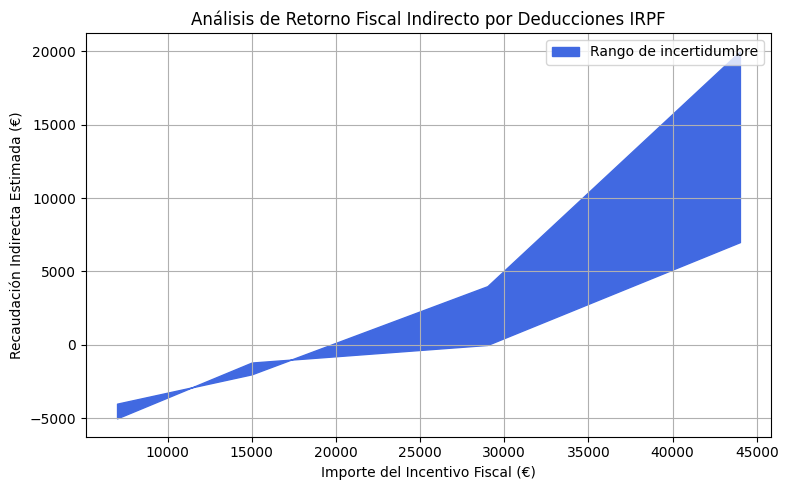

In [53]:
plot_recaudacion_vs_inversion(df_esp)

In [44]:
import numpy as np
import pandas as pd

def resumen_recaudacion(df_resumen):
    """
    Genera una tabla resumen con % de recaudación sobre dinero invertido
    para recaudación mínima, media y máxima.

    Parameters
    ----------
    df_resumen : pd.DataFrame

    Returns
    -------
    pd.DataFrame
    """
    df = df_resumen.copy()

    # Calcular % para cada tipo de recaudación
    for col in ["recaudacion_min", "recaudacion_media", "recaudacion_max"]:
        pct_col = f"porcentaje_{col}"
        df[pct_col] = np.where(
            df["dinero_invertido"] != 0,
            (df[col] / df["dinero_invertido"]) * 100,
            np.nan
        )
        df[pct_col] = df[pct_col].round(2)
        df[col] = df[col].round(2)

    df["dinero_invertido"] = df["dinero_invertido"].round(2)

    cols_final = [
        "escenario",
        "dinero_invertido",
        "recaudacion_min", "porcentaje_recaudacion_min",
        "recaudacion_media", "porcentaje_recaudacion_media",
        "recaudacion_max", "porcentaje_recaudacion_max"
    ]

    df_final = df[cols_final]

    return df_final


In [45]:
df_resultados = resumen_recaudacion(df_esp)

df_resultados.head()

,escenario,dinero_invertido,recaudacion_min,porcentaje_recaudacion_min,recaudacion_media,porcentaje_recaudacion_media,recaudacion_max,porcentaje_recaudacion_max
0,Austero,7000,-5000,-71.43,-4500,-64.29,-4000,-57.14
1,Moderado,15000,-2000,-13.33,-1500,-10.00,-1000,-6.67
2,Generoso,29000,3000,10.34,3500,12.07,4000,13.79
3,Nordico,44000,7000,15.91,7500,17.05,8000,18.18


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def graficar_diferencias_por_categoria(
    df_dif_categorias,
    top_n=60,
    figsize=(15,10),
    ordenar=True
):
    """
    Grafica la diferencia de gasto por categoría y escenario.

    Parameters
    ----------
    df_dif_categorias : pd.DataFrame
        DataFrame con columnas:
        - 'escenario'
        - 'categoria'
        - 'gasto_incrementado'

    top_n : int
        Número de categorías más relevantes a mostrar (por suma absoluta de diferencias).
        Si None, muestra todas.

    figsize : tuple
        Tamaño del gráfico (anchura, altura).

    ordenar : bool
        Si True, ordena las barras por magnitud del gasto incremental.

    Returns
    -------
    None
    """

    # Filtrar solo gastoMonetario (si quieres incluir solo esas categorías)
    df_plot = df_dif_categorias[
        df_dif_categorias["categoria"].str.startswith("gastoMonetario:")
    ].copy()

    # Quitar prefijo para que el gráfico sea más legible
    df_plot["categoria_simple"] = df_plot["categoria"].str.replace(
        "gastoMonetario:", "", regex=False
    )

    # Seleccionar solo top_n categorías si se indica
    if top_n is not None:
        suma_abs = (
            df_plot
            .groupby("categoria_simple")
            .agg(total_abs=("gasto_incrementado", lambda x: x.abs().sum()))
            .reset_index()
            .sort_values("total_abs", ascending=False)
        )
        categorias_top = suma_abs.head(top_n)["categoria_simple"].tolist()
        df_plot = df_plot[df_plot["categoria_simple"].isin(categorias_top)]

    # Ordenar las categorías si se desea
    if ordenar:
        orden_categorias = (
            df_plot
            .groupby("categoria_simple")["gasto_incrementado"]
            .sum()
            .sort_values(ascending=False)
            .index
        )
    else:
        orden_categorias = None

    plt.figure(figsize=figsize)
    sns.barplot(
        data=df_plot,
        x="categoria_simple",
        y="gasto_incrementado",
        hue="escenario",
        order=orden_categorias
    )
    plt.xticks(rotation=90)
    plt.ylabel("Variación del gasto (€)")
    plt.title("Diferencia de gasto por categoría y escenario")
    plt.tight_layout()
    plt.show()


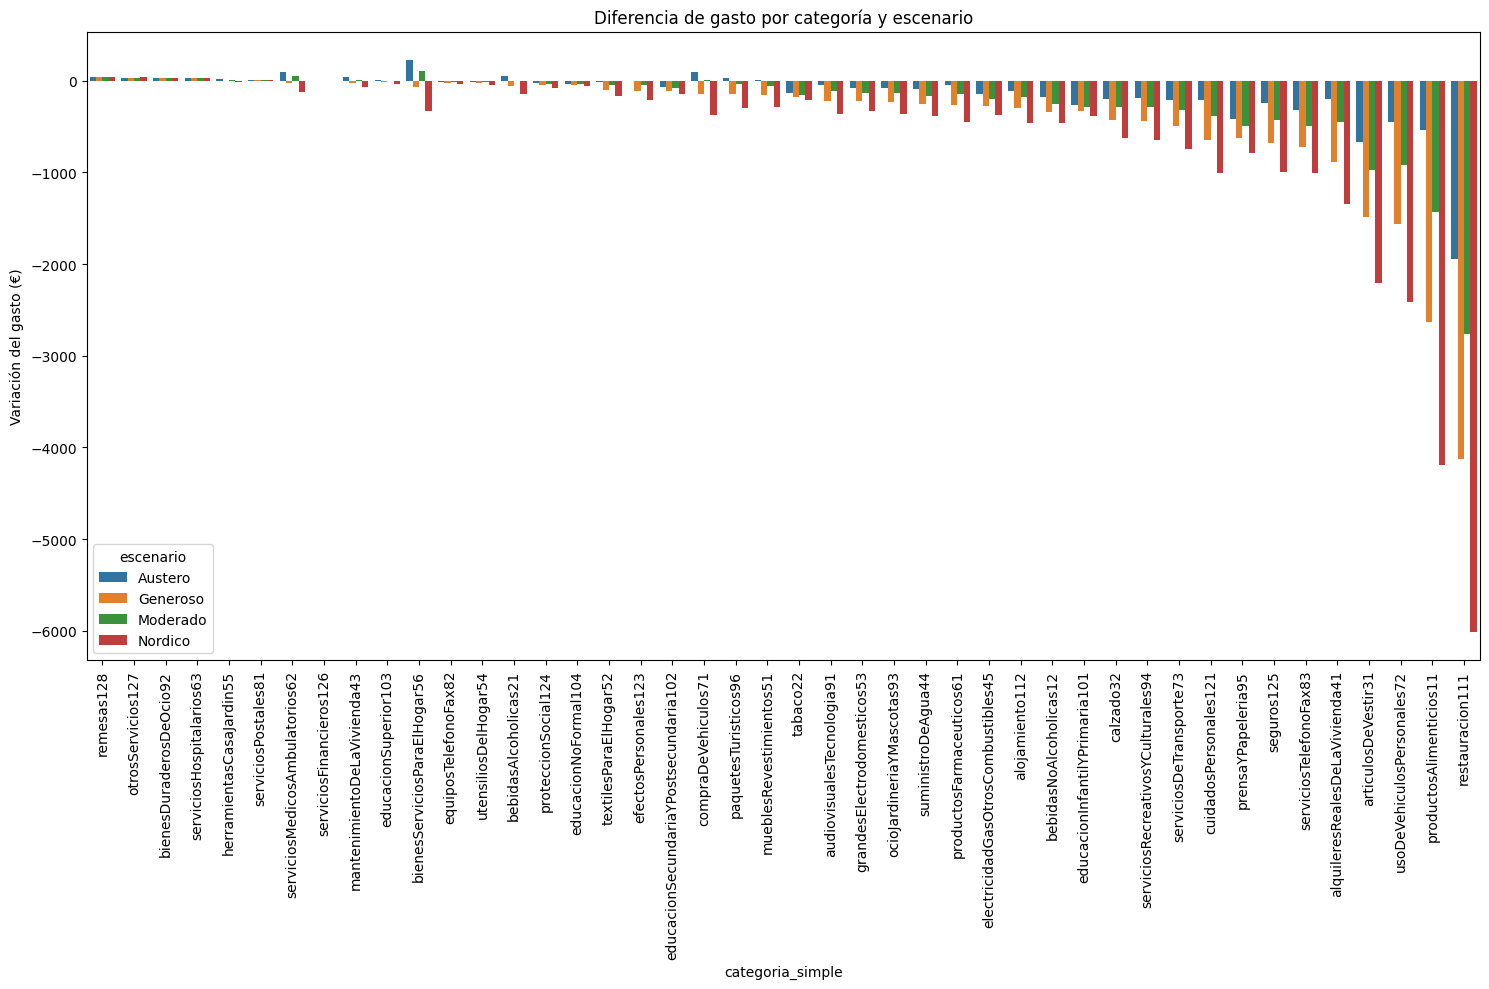

In [ ]:
graficar_diferencias_por_categoria(
    df_dif_cat_esp)